# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import data
dfraw=pd.read_pickle("WM811K.pkl")

# Drop unused columns
dfraw.drop(columns=['lotName','waferIndex','dieSize','trainTestLabel'],inplace=True)

# Rename columns
rename = {'failureType':'Defect_Class',
          'waferMap':'Wafer_Map'}
dfraw.rename(columns=rename,inplace=True)

# Visualize
dfraw.info()
dfraw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Defect_Class  811457 non-null  object
 1   Wafer_Map     811457 non-null  object
dtypes: object(2)
memory usage: 12.4+ MB


,Defect_Class,Wafer_Map
0,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,none,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


<table>
    <tr>
        <th>Column</th>
        <th>Description</th>
        <th>Type</th>
    </tr>
    <tr>
        <td>Wafer_Map</td>
        <td>List of whether defect is present by location on wafer (2 is yes, 1 is no, 0 is background)</td>
        <td>Object</td>
    </tr>
    <tr>
        <td>Defect_Class</td>
        <td>Classification of defects based on wafer map</td>
        <td>Object</td>
    </tr>
</table>

### Defect_Class Column

Defects are classified into several values, and defects with no clear shape/location are classified as Random. "[0 0]" represents wafermaps that were not classified, and "none" represents wafer maps that were classified, but no significant defects were observed. We will only drop the unclassified data.

In [2]:
# Ensure column is a string
dfraw['Defect_Class'] = dfraw['Defect_Class'].astype(str)

# Drop unclassified data
dfraw = dfraw[dfraw['Defect_Class'] != '[0 0]']
shape = dfraw.shape
print(f'Shape after dropping unclassified defect values: {shape}')

Shape after dropping unclassified defect values: (172950, 2)


### Wafer_Map Column

Clean null / empty list / nonlist entries.

In [3]:
# Check for null, empty lists, nonlist entries.
Null = dfraw['Wafer_Map'].isnull()
NonlistorEmpty = dfraw['Wafer_Map'].apply(lambda x: len(x) == 0 if isinstance(x, list) else False)

# Boolean combination
Cleaner = Null | NonlistorEmpty

# Remove rows with null, empty lists, or nonlist entries.
dfraw = dfraw[~Cleaner]

### Visualization of Wafer Maps

As a final step, let's visualize our wafer map data. The goal is the ensure defect classification is accurate visually. 2nd goal is to ensure that defects classified as "none" show no significant defect patterns.

In [4]:
# Create dataframe with Defect_Class = 'none' only
dfNone = dfraw[dfraw['Defect_Class'] == 'none']

# Create dataframe with classified Defect_Class
dfClassified = dfraw[dfraw['Defect_Class'] != 'none']

In [5]:
# Define function for repeatability of plotting
def plot_wafer_maps(df, number_of_subplots):
    """
    
    Plots first number_of_subplots of wafer map images from df dataframe using Wafer_Map and Defect_Class columns.
    Creates grid of subplots. Please only input number_of_subplots in units of 10.
    
    """
    dfreset = df.reset_index()
    nrows = int(number_of_subplots / 10)
    fig, ax = plt.subplots(nrows = nrows, ncols = 10, figsize=(20, nrows * 2))
    ax = ax.ravel(order='C')         #This is necessary to loop all subplots with 1 index
    for i in range(number_of_subplots):
        img = dfreset.Wafer_Map[i]
        ax[i].imshow(img)
        title = f'{dfreset.index[i]} - {dfreset.Defect_Class[i]}'
        ax[i].set_title(title)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show() 

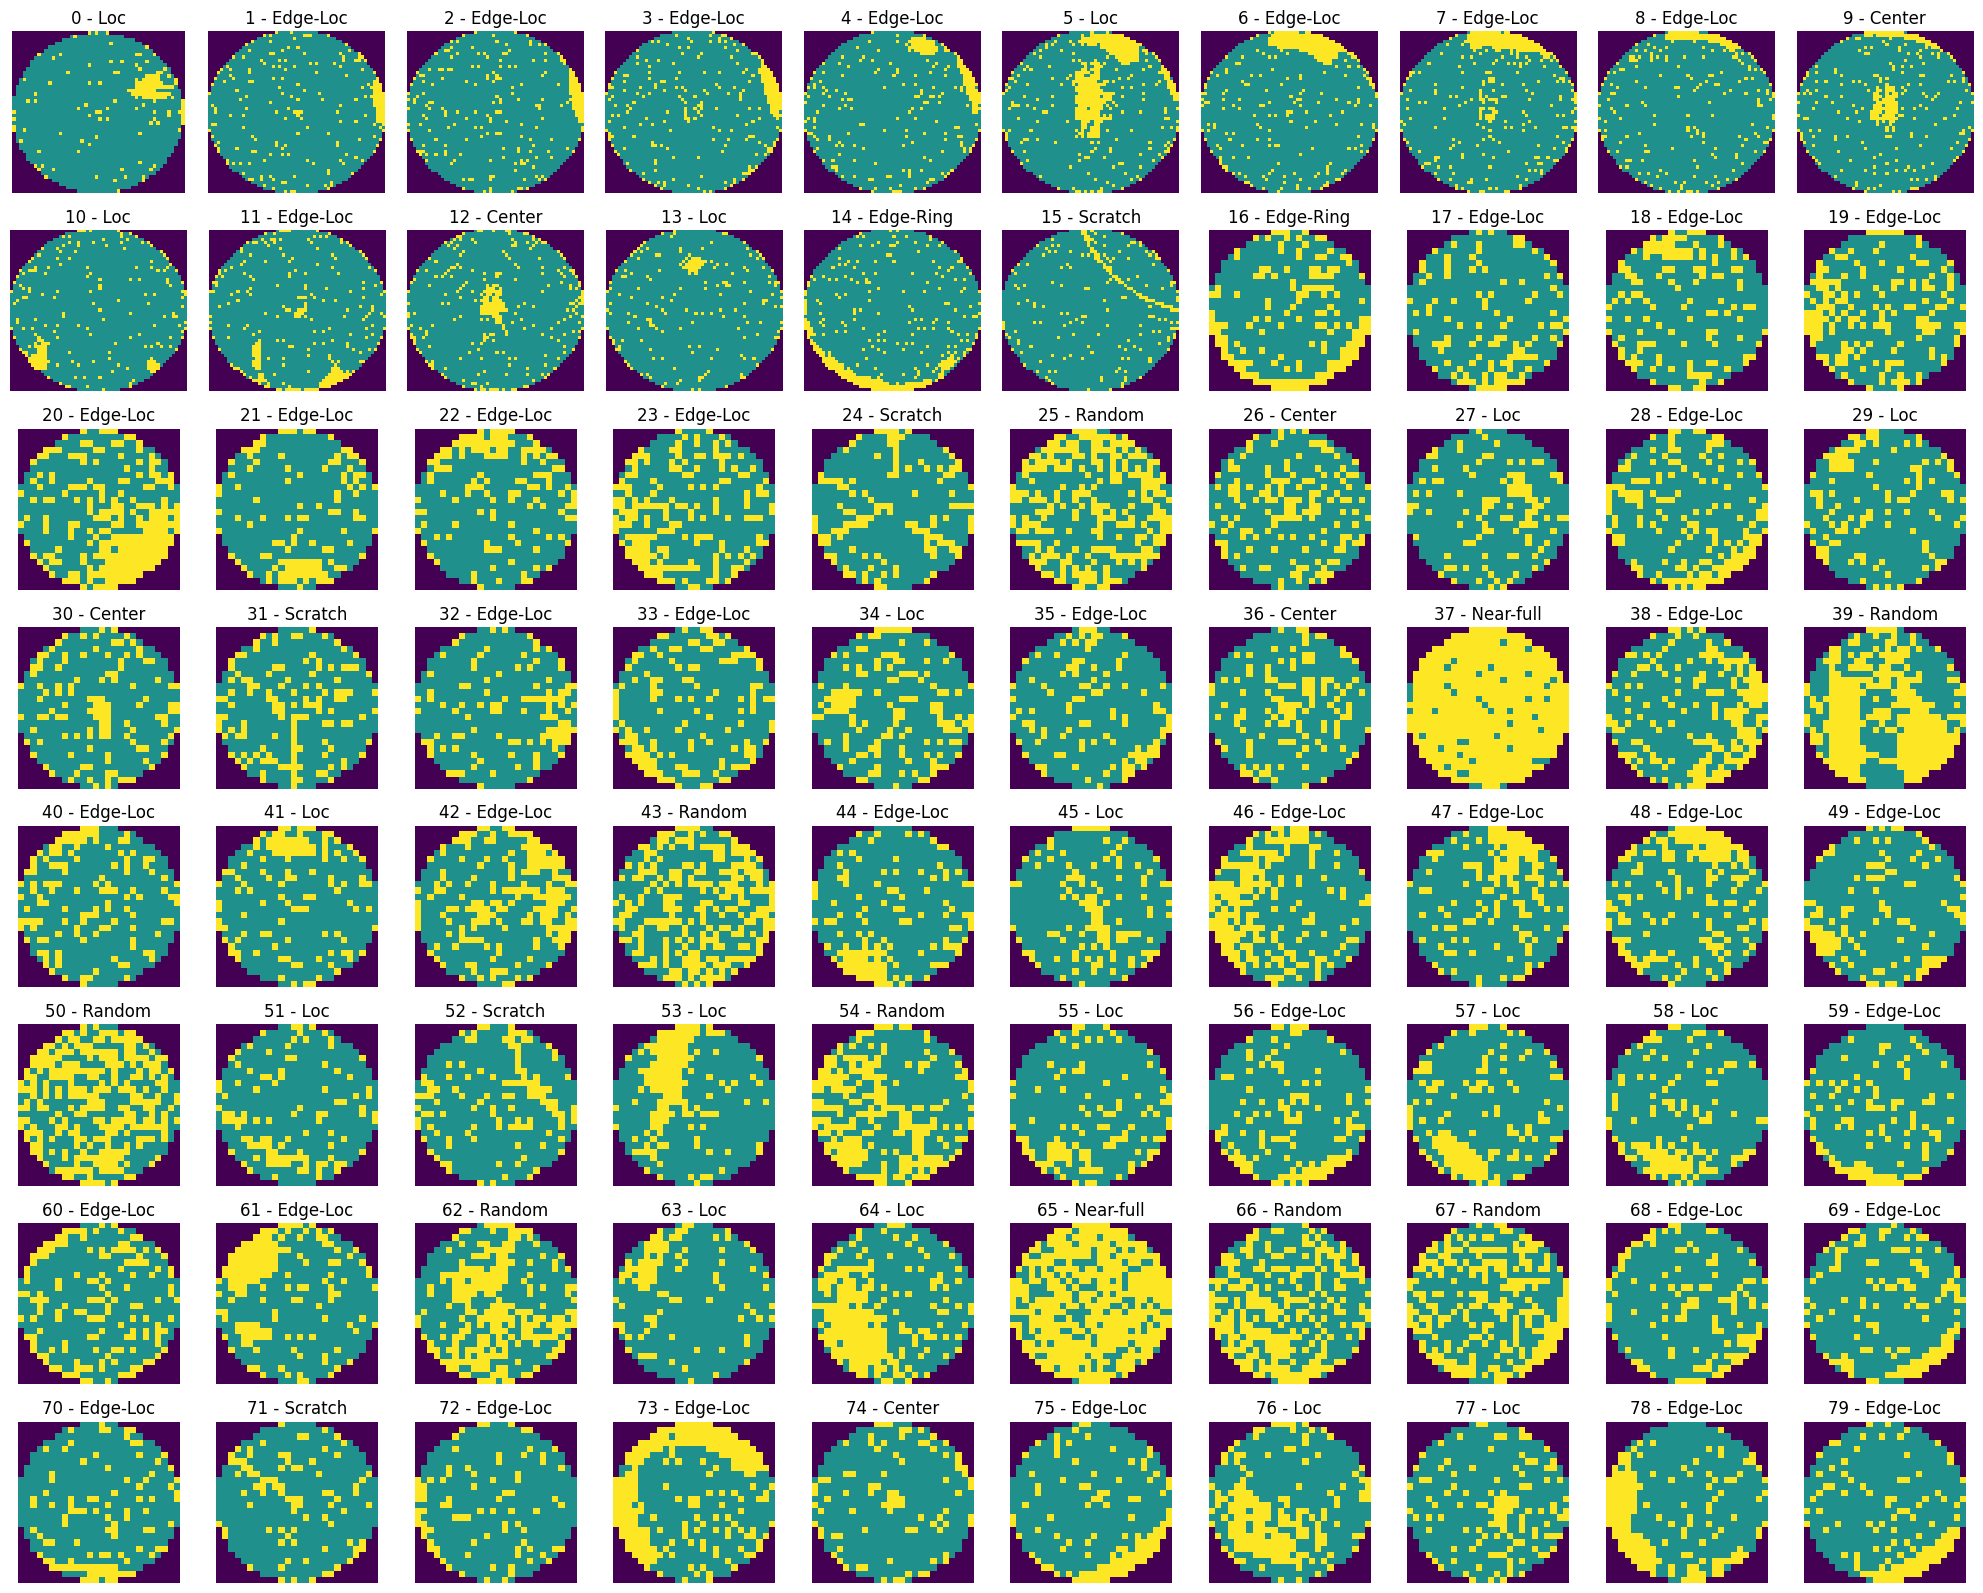

In [6]:
# Plot Classified Data
plot_wafer_maps(dfClassified, 80)

Above plots show that wafers can have more than 1 type of classified defect. For example, index 3 shows Edge-Loc and Loc defects, but is labeled only as Loc. This is a limitation of our dataset which only labels the largest defect appropriately since only 1 defect classification per wafer map is allowed. Therefore, wafers with multiple defect patterns may affect our results classification + bounding boxes

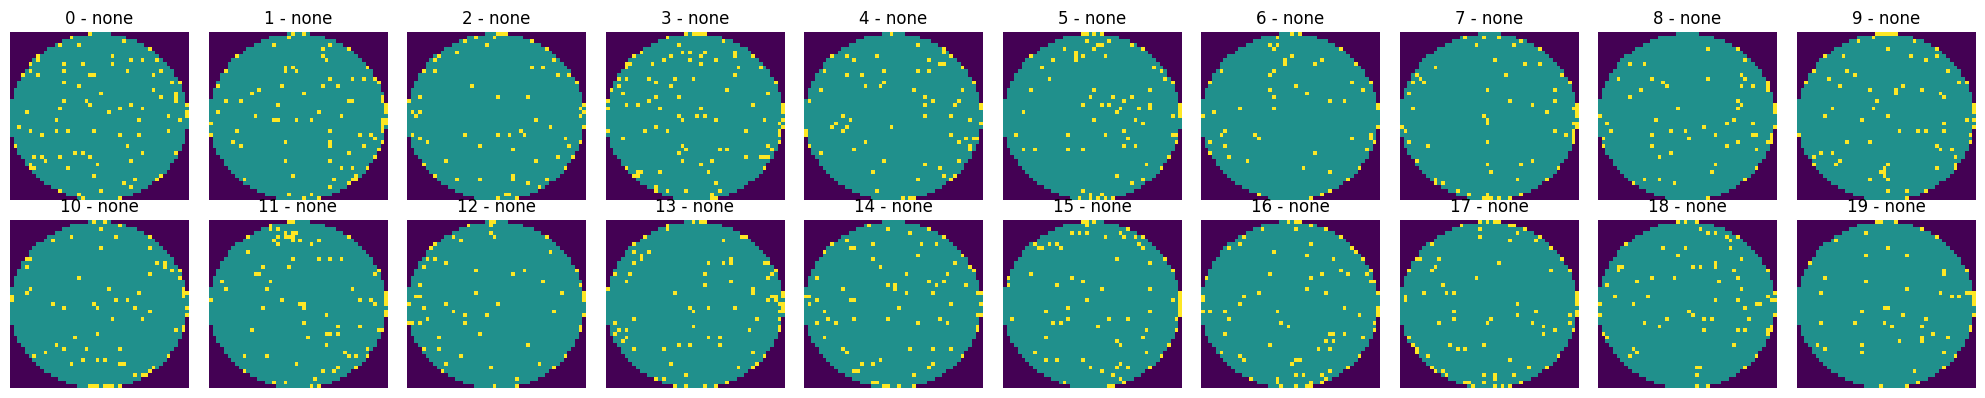

In [7]:
#Plot None Data
plot_wafer_maps(dfNone, 20)

Not all wafermaps are the same dimensions, so let's check where our distributions lie in case cleaning is needed.

In [8]:
def dimension(x):
    '''
    
    This will return the dimension of a 2D array x.
    
    '''
    rows = np.size(x,axis=0)
    columns = np.size(x,axis=1)
    return rows,columns

In [9]:
# Create dataframe of wafer map dimensions
dfdimensions=dfraw.Wafer_Map.apply(dimension)

# Display value counts
value_counts_dimensions = dfdimensions.value_counts().sort_index()
display(value_counts_dimensions)

Wafer_Map
(15, 3)         1
(18, 4)         1
(18, 44)        1
(22, 35)        2
(22, 50)      899
             ... 
(143, 132)     10
(152, 172)     11
(153, 187)      2
(155, 175)     48
(212, 84)       8
Name: count, Length: 346, dtype: int64

The smallest wafer map we have is 15x3. This resolution is very low, and may throw off classification. Let's remove wafer maps that have dimensions that are relatively too small.

In [10]:
# Calculate Area from dimensions
dfarea = dfdimensions.apply(lambda dimensions: dimensions[0] * dimensions[1])

# Display value counts of area
value_counts_area = dfarea.value_counts().sort_index()
display(value_counts_area)

Wafer_Map
45        1
72        1
312       1
405       1
432       1
         ..
19710     9
24888     3
26144    11
27125    48
28611     2
Name: count, Length: 314, dtype: int64

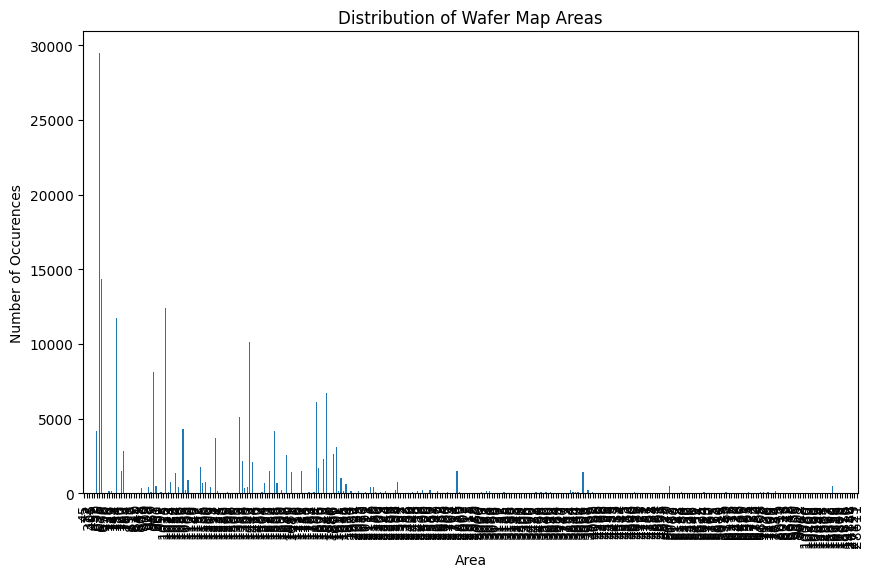

In [11]:
# Plot area in bar chart
plt.figure(figsize=(10, 6))
value_counts_area.plot(kind='bar')
plt.xlabel('Area')
plt.ylabel('Number of Occurences')
plt.title('Distribution of Wafer Map Areas')
plt.show()

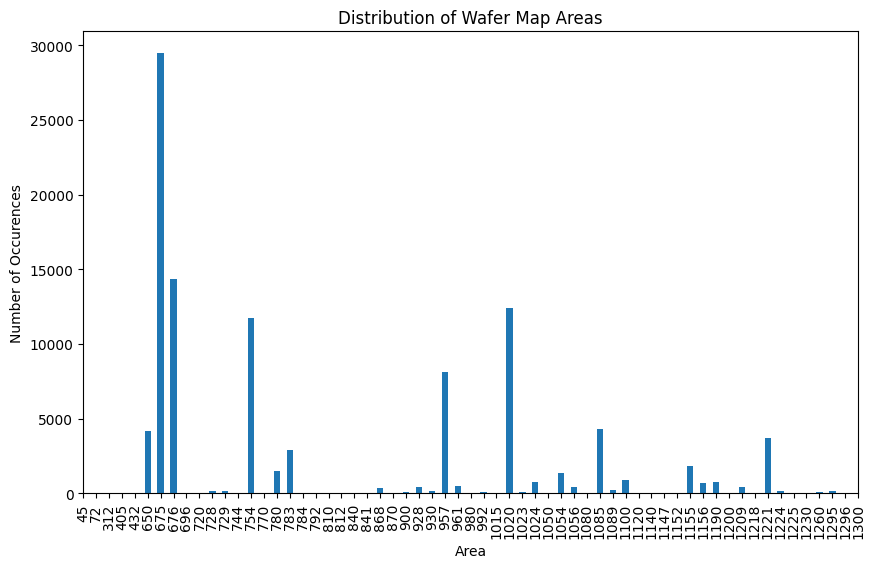

In [12]:
#Plot area in bar chart
plt.figure(figsize=(10, 6))
value_counts_area.plot(kind='bar')
plt.xlabel('Area')
plt.ylabel('Number of Occurences')
plt.xlim(0,60)
plt.title('Distribution of Wafer Map Areas')
plt.show()

Highest counts of area are at 675. We also have lots of data at 650, so let's remove any rows with area less than 650.

In [13]:
# Remove rows where area is less than 650 
dfraw = dfraw[dfarea >= 650]

### Removing Isolated Defects

 To simplify classification, we will drop all defects that have no neighboring defects which does not affect our defect patterns for classification and might even improve interpretation of model.

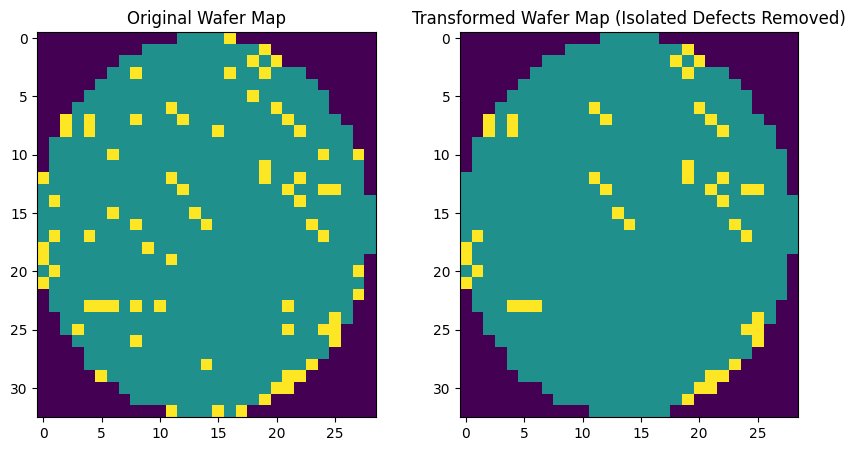

In [14]:
from scipy.ndimage import generic_filter
from joblib import Parallel, delayed

clean_df=dfraw

def remove_isolated_defects(wafer_map):
    """
    Converts isolated defect pixels to non-defect if all 8 neighboring pixels are either 1 or 0.
    """
    def filter_function(values):
        center = values[4]
        neighbors = np.delete(values, 4)
        if center == 2 and np.all(np.isin(neighbors, [0, 1])):
            return 1
        return center

    # Apply the filter with a 3x3 moving window
    return generic_filter(wafer_map, filter_function, size=(3, 3), mode='constant', cval=1)

# Select a random wafer map for visualization
sample_idx = np.random.choice(clean_df.index)
original_wafer_map = clean_df.loc[sample_idx, 'Wafer_Map']

# Apply transformation for visualization
transformed_wafer_map = remove_isolated_defects(original_wafer_map)

# Apply transformation to all wafer maps
clean_df['Wafer_Map'] = Parallel(n_jobs=-1)(
    delayed(remove_isolated_defects)(wm) for wm in clean_df['Wafer_Map']
)

# Plot original and transformed wafer maps
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_wafer_map, cmap='viridis')
axes[0].set_title("Original Wafer Map")
axes[1].imshow(transformed_wafer_map, cmap='viridis')
axes[1].set_title("Transformed Wafer Map (Isolated Defects Removed)")
plt.show()

### Addressing Wafer_Map Dimensions

Not all wafer maps are the same dimensions which needs to be addresed before feature creation

In [15]:
def average_wafer_dimension(clean_df):
    """
    Computes the average wafer map dimension
    """
    avg_area = clean_df['Wafer_Map'].apply(lambda x: np.prod(x.shape)).mean()
    avg_dimension = int(np.round(np.sqrt(avg_area)))
    return avg_dimension

# Compute
avg_wafer_dim = average_wafer_dimension(clean_df)
print(f"Average Wafer Map Dimension: {avg_wafer_dim} x {avg_wafer_dim}")

Average Wafer Map Dimension: 37 x 37


We will use 45 x 45 to mimize distortion of maps, while maintaining enough detail, while making wafer maps easy to handle for classification. Nearest-neighbor interpolation was performed

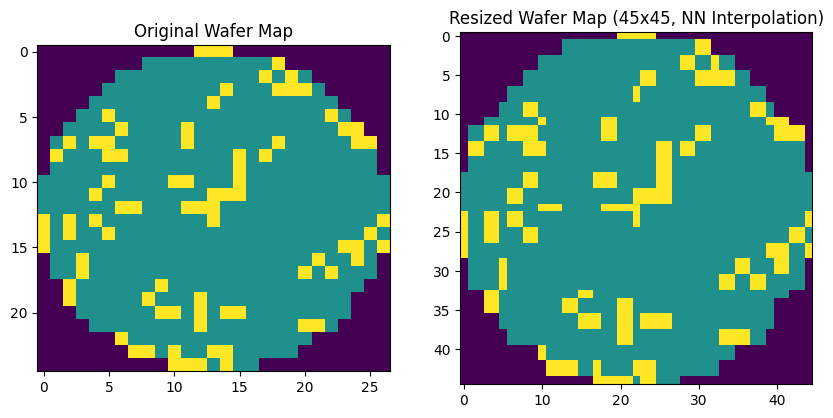

In [16]:
import scipy.ndimage

# Define resizing function with nearest-neighbor interpolation
def resize_wafer_nn(wafer_map, target_size=(45, 45)):
    zoom_factors = (target_size[0] / wafer_map.shape[0], target_size[1] / wafer_map.shape[1])
    return scipy.ndimage.zoom(wafer_map, zoom_factors, order=0)

# Select one map for visualization
sample_idx = np.random.choice(clean_df.index)
original_wafer_map = clean_df.loc[sample_idx, 'Wafer_Map']

# Resize
resized_wafer_map = resize_wafer_nn(original_wafer_map, target_size=(45, 45))

# Apply resizing to all
clean_df['Wafer_Map'] = clean_df['Wafer_Map'].apply(lambda x: resize_wafer_nn(x, target_size=(45, 45)))

# Plot sample wafer map
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_wafer_map, cmap='viridis')
axes[0].set_title("Original Wafer Map")
axes[1].imshow(resized_wafer_map, cmap='viridis')
axes[1].set_title("Resized Wafer Map (45x45, NN Interpolation)")
plt.show()

In [17]:
avg_wafer_dim = average_wafer_dimension(clean_df)
print(f"Average Wafer Map Dimension: {avg_wafer_dim} x {avg_wafer_dim}")

Average Wafer Map Dimension: 45 x 45


Based on visual inspections, our interpolation produced good results.

Simplify wafer map (to 1 and 0 only) since all are same scale

In [18]:
def simplify_wafer_map(wafer_map):
    arr = np.array(wafer_map)
    arr = np.where(arr == 2, 1, 0)
    return arr.astype(np.uint8)
clean_df["Wafer_Map"] = clean_df["Wafer_Map"].apply(simplify_wafer_map)

# Save to pkl
clean_df.to_pickle("WM811K_clean.pkl")

### Turn Wafer_Map to Image data for drawing bounding boxes

In [2]:
import cv2
import os
import numpy as np
import pandas as pd

# Import pickle
clean_df = pd.read_pickle("WM811K_clean.pkl")

# Create directory
output_dir = "images"
os.makedirs(output_dir, exist_ok=True)

# Save images
for i, (wafer, defect_class) in enumerate(zip(clean_df["Wafer_Map"], clean_df["Defect_Class"])):
    img = (np.array(wafer) * 255).astype(np.uint8)
    # Name with defect class
    safe_class = str(defect_class).replace(" ", "_").lower()
    filename = f"{safe_class}_{i}.png"
    filepath = os.path.join(output_dir, filename)
    cv2.imwrite(filepath, img)